In [1]:
#|default_exp conv

# Convolutions

## Setup

In [2]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [3]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
import torch.nn.functional as F

from torch.utils.data import DataLoader
from typing import Mapping

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

## Intuition
Convolution is a structure that we provide the neural network to give it a better context of the problem. It occurs in many domains, most notably images. It also applies to domains like audio, words etc, where there is a spatial relationship between 2 elements that are close together.

In this notebook, we will focus on images. We can think of filters as finding edges in the earlier layers of a CNN, then combining those edges to get more complicated shapes (e.g. curves, eyes).

In [6]:
x_imgs = x_train.view(-1, 28, 28)
x_imgs.shape

torch.Size([50000, 28, 28])

In [7]:
xv_imgs = x_valid.view(-1, 28, 28)

In [8]:
mpl.rcParams['figure.dpi'] = 30

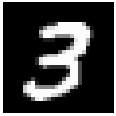

In [9]:
im3 = x_imgs[7]
show_image(im3);

### Edges

In [10]:
top_edge = tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=torch.float)

Let us look at the intensity of some portion of the image 3 above.

In [11]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [12]:
top_edge.shape

torch.Size([3, 3])

In [13]:
im3[4:7, 14:17]

tensor([[0.0000, 0.0000, 0.0000],
        [0.9961, 0.9883, 0.9883],
        [0.9883, 0.9844, 0.9844]])

In [14]:
(top_edge * im3[4:7, 14:17]).sum()

tensor(2.9570)

Our top edge filter gives us a large positive value when we transition from light to dark across the vertical axis.

In [15]:
im3[8:11, 10:13]

tensor([[0.9844, 0.9844, 0.8984],
        [0.1133, 0.1133, 0.0938],
        [0.0000, 0.0000, 0.0000]])

In [16]:
(top_edge * im3[8:11, 10:13]).sum()

tensor(-2.8672)

Our top edge filter gives us a large negative value when we transition from dark to light across the vertical axis.

In [17]:
def apply_kernel(img, row, col, kernel):
    return (kernel * img[row:row+3, col:col+3]).sum()

In [18]:
apply_kernel(im3, 8, 10, top_edge)

tensor(-2.8672)

In [19]:
n = im3.shape[0] - 3 + 1
indices = [(i, j) for i in range(n) for j in range(n)]
indices

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 23),
 (3, 24),
 (3, 25),


In [20]:
results = torch.zeros(n, n)
results

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0.,

<Axes: >

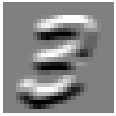

In [21]:
for element in indices:
    i, j = element
    results[i, j] = apply_kernel(im3, i, j, top_edge)

show_image(results)

In [22]:
def get_kernel_out(img, indices, kernel):
    result = torch.zeros(img.shape[0]-2, img.shape[0]-2)
    for element in indices:
        i, j = element
        result[i, j] = apply_kernel(img, i, j, kernel)

    return result

We can see that the top edges are highlighted (brighter with white color). Now let's try repeat the following with `left_edge`.

In [23]:
left_edge = torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=torch.float)
left_edge

tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]])

In [24]:
left_out = get_kernel_out(im3, indices, left_edge)

<Axes: >

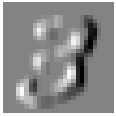

In [25]:
show_image(left_out)

Likewise, we can see that `left_edge` highlights the left edges.

## Convolutions in PyTorch
We see that we can calculate the product of kernel across each image using the looping approach that we did above. However, this is very slow. We want to speed things up using matrix multiplication.
We unfold the kernel and input image by:
- unfolding each 'kernel space' of the input image as a row in the reshaped matrix
- unfolding each kernel as a column

This is hard to understand verbally, so it'll be best to view the [image of this unfolding](https://www.researchgate.net/profile/Wentai-Zhang-6/publication/342112418/figure/fig1/AS:902354379481088@1592149457294/The-im2col-GEMM-explicit-GEMM-method.png).

We can use `F.unfold` to do this reshaping of the input tensor.
`torch.nn.functional.unfold(input, kernel_size, dilation=1, padding=0, stride=1)`

In [26]:
inp = im3[None, None,:]
inp.shape

torch.Size([1, 1, 28, 28])

In [27]:
unfolded_inp = F.unfold(inp, (3,3))[0]
unfolded_inp.shape

torch.Size([9, 676])

In [28]:
unfold_top_edge = top_edge.view(-1)
unfold_top_edge.shape

torch.Size([9])

In [29]:
(unfold_top_edge@unfolded_inp).shape

torch.Size([676])

In [30]:
unfolded_top_out = (unfold_top_edge@unfolded_inp).reshape(26, 26)

<Axes: >

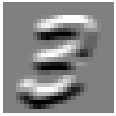

In [31]:
show_image(unfolded_top_out)

Let's look at the speed-up from implementing a matrix multiplication.

In [32]:
%timeit -n 1 get_kernel_out(im3, indices, left_edge)

5.86 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit -n 100 (unfold_top_edge@F.unfold(inp, (3,3))[0]).reshape(26,26)

80 µs ± 33.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We see a ~1500 speedup!

## `F.conv2d`
We can use [`F.conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) which takes in a batch of input images and a batch of kernels, and apply the kernel over them.

In [34]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

<Axes: >

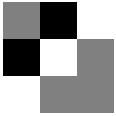

In [35]:
show_image(diag1_edge)

In [36]:
diag2_edge = tensor([[ 1,-1, 0],
                     [0, 1, -1],
                     [ 0, 0, 1]]).float()

<Axes: >

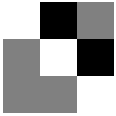

In [37]:
show_image(diag2_edge)

In [38]:
kernels = torch.stack((top_edge, left_edge, diag1_edge, diag2_edge), dim=0).unsqueeze(1)
kernels.shape

torch.Size([4, 1, 3, 3])

In [39]:
xb = x_imgs[:16].unsqueeze(1)
xb.shape

torch.Size([16, 1, 28, 28])

In [40]:
batch_edges = F.conv2d(xb, kernels)

In [41]:
xb[0,0].shape

torch.Size([28, 28])

<Axes: >

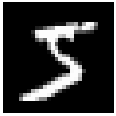

In [42]:
show_image(xb[0,0])

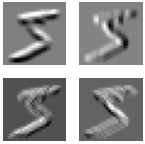

In [43]:
show_images([batch_edges[0,i] for i in range(4)])

We see the edges being highlighted in `batch_edges`.

### Strides and padding

We want to control the size of the output dimension after each convolution. To do so, we can use the formula: $ outputSize = \frac{inputSize - kernelSize + 2 \times padding}{stride} + 1$.
If we want to maintain the same input and output shape (assuming stride of 1), we need padding of `ks//2` on each side (assuming that `ks` is an odd number).

Let's create a `conv` function using [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

In [53]:
#|export
# ni: input dimension, nf: filter dimension
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU()) # non-linear activation
    return res

For now, we want to end up with 10 channels and a `output_size` of 1. We will then use the softmax each of the value at the 10 channels as the probability of each MNIST class.

In [85]:
simple_cnn = nn.Sequential(
    conv(1, 4), # 14 by 14
    conv(4, 8), # 7 by 7
    conv(8, 16), # 4 by 4
    conv(16, 16), # 2 by 2
    conv(16, 10, act=False), # 1 by 1
    nn.Flatten()
)

In [86]:
xb.shape

torch.Size([16, 1, 28, 28])

In [87]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [89]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)
x_imgs.shape, xv_imgs.shape

(torch.Size([50000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [98]:
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [99]:
# Checks if GPU is available on Mac
print(torch.backends.mps.is_available())

True


In [100]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [101]:
from torch import optim

bs=256
lr=0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [102]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.16128179366588594 0.9474000004768371
1 0.11302323184013367 0.9675999994277954
2 0.09459489917755128 0.9710999994277955
3 0.15313652288913726 0.9548000008583069
4 0.14104804880619048 0.9540000008583069


We see that we are getting results comparable to our MLP! However, we are using much fewer parameters (weights and biases) in our CNN compared to our MLP.

For the MLP, we had 38400 (768 by 50) weights + 50 biases in the hidden layer, and a 500 (50 by 10) weights + 10 biases. The total number of parameters is 38960.

For our CNN, we can calculate it using the following code.

In [103]:
total_params = 0
for param in simple_cnn.parameters():
    total_params += param.numel()

total_params

5274

We have around a 7x savings in number of parameters.

# Export

In [105]:
import nbdev; nbdev.export.nb_export('07_convolutions.ipynb', lib_path='miniai')